<a href="https://colab.research.google.com/github/AldaCL/Deep-Learning-Notes/blob/main/Efect_of_deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16110283.22it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 415245.02it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4453472.78it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2642237.00it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training with 32 neurons in the hidden layer.
Training with 64 neurons in the hidden layer.
Training with 128 neurons in the hidden layer.
Training with 256 neurons in the hidden layer.


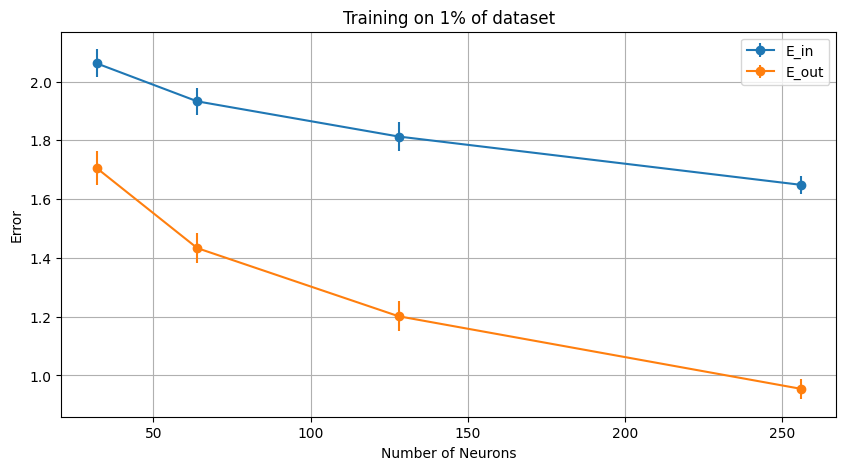

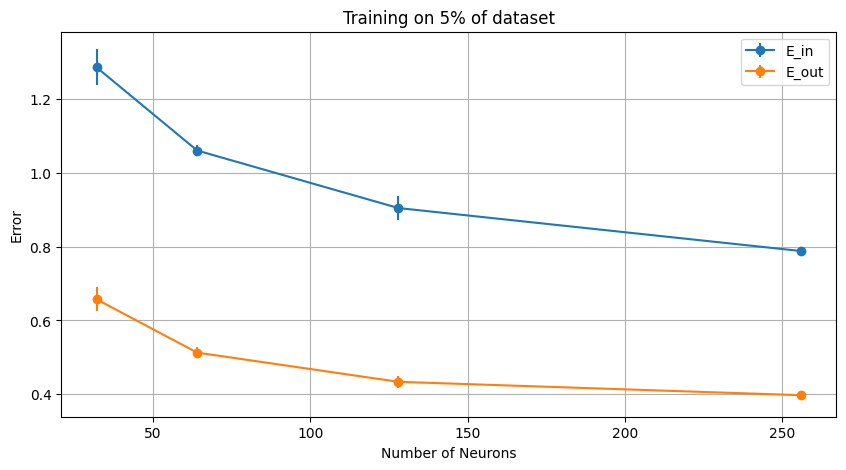

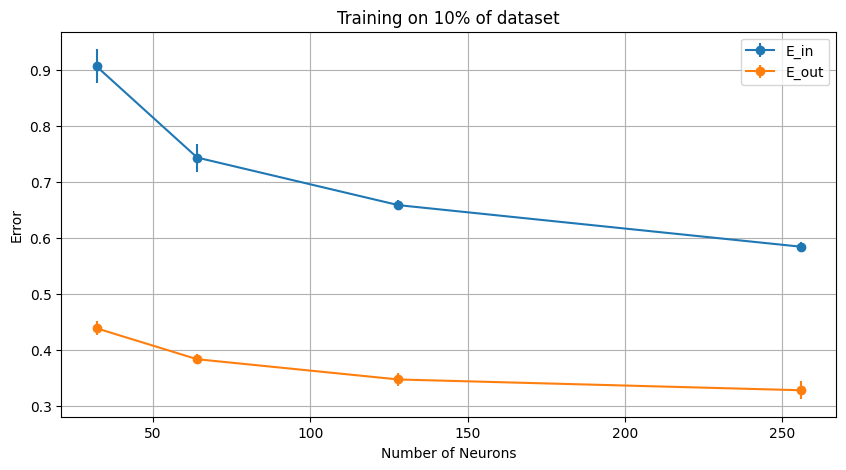

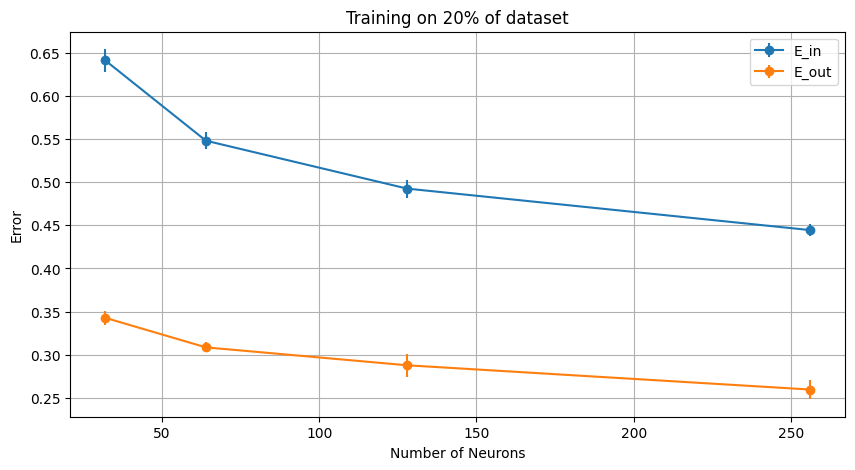

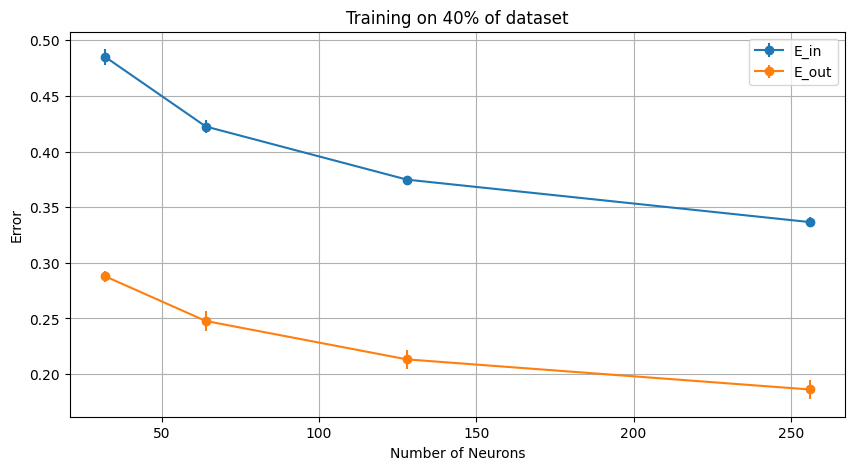

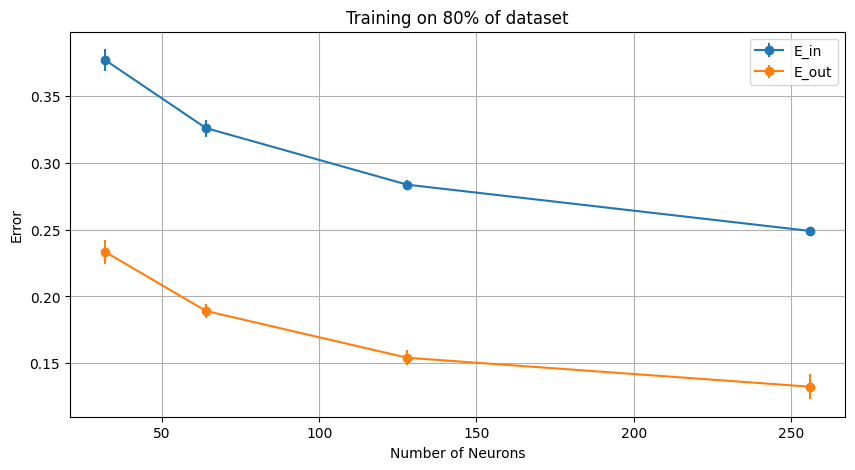

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hyperparameters
batch_size = 64
epochs = 5
T = 10  # Number of experiments

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader_full = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# SNN model definition
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train the model
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += data.size(0)
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

# Test the model
def test(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.size(0)
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

# Experiment settings
neuron_sizes = [32, 64, 128, 256]
dataset_sizes = [0.01, 0.05, 0.1, 0.2, 0.4, 0.8]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 28 * 28
num_classes = 10

# Arrays to store results
results_in = {size: [] for size in dataset_sizes}
results_out = {size: [] for size in dataset_sizes}

# Main loop for experiments
for s in neuron_sizes:
    print(f"Training with {s} neurons in the hidden layer.")
    for ds_size in dataset_sizes:
        E_in_list = []
        E_out_list = []
        num_samples = int(len(train_dataset) * ds_size)
        for t in range(T):
            # Sample a subset of the training data
            subset_indices = np.random.choice(len(train_dataset), num_samples, replace=False)
            train_loader = DataLoader(Subset(train_dataset, subset_indices), batch_size=batch_size, shuffle=True)

            # Initialize model, criterion, optimizer
            model = SimpleNN(input_size=input_size, hidden_size=s, num_classes=num_classes).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001)

            # Train the model
            train_loss, _ = train(model, train_loader, criterion, optimizer, device)

            # Test the model
            test_loss, _ = test(model, test_loader, criterion, device)

            E_in_list.append(train_loss)
            E_out_list.append(test_loss)

        # Store the mean and std deviation of errors
        E_in_mean = np.mean(E_in_list)
        E_out_mean = np.mean(E_out_list)
        E_in_std = np.std(E_in_list)
        E_out_std = np.std(E_out_list)

        results_in[ds_size].append((E_in_mean, E_in_std))
        results_out[ds_size].append((E_out_mean, E_out_std))

# Plotting results
for ds_size in dataset_sizes:
    means_in = [result[0] for result in results_in[ds_size]]
    stds_in = [result[1] for result in results_in[ds_size]]

    means_out = [result[0] for result in results_out[ds_size]]
    stds_out = [result[1] for result in results_out[ds_size]]

    plt.figure(figsize=(10, 5))
    plt.errorbar(neuron_sizes, means_in, yerr=stds_in, label="E_in", fmt='-o')
    plt.errorbar(neuron_sizes, means_out, yerr=stds_out, label="E_out", fmt='-o')
    plt.title(f"Training on {ds_size*100:.0f}% of dataset")
    plt.xlabel("Number of Neurons")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)
    plt.show()


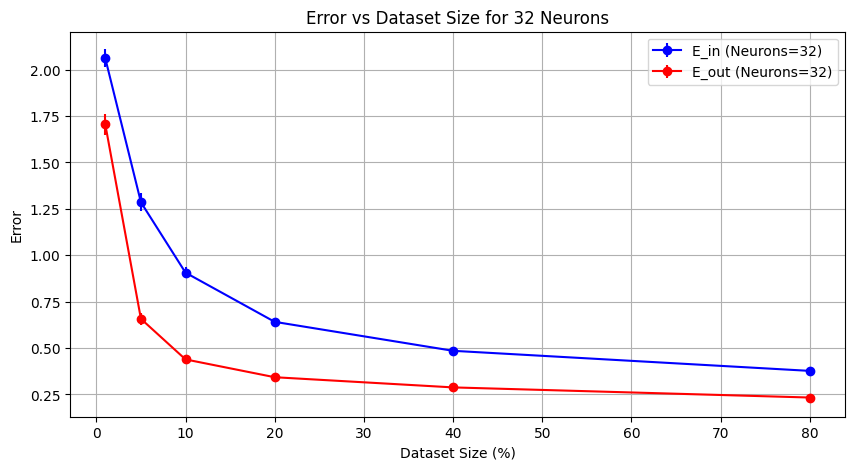

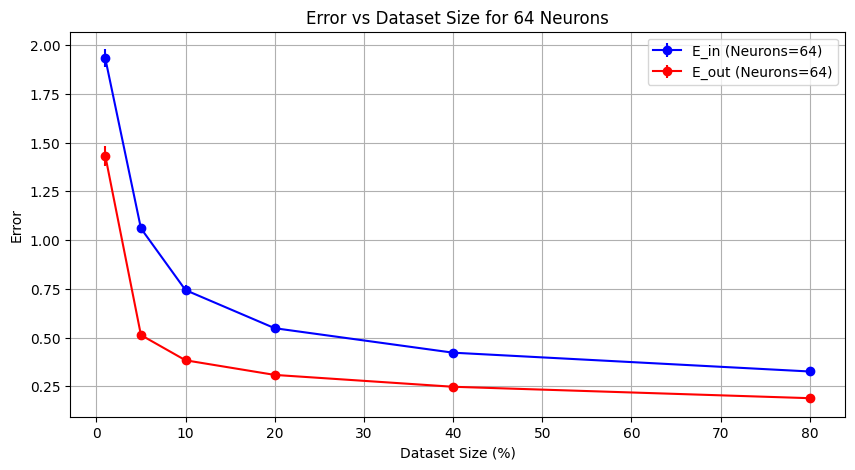

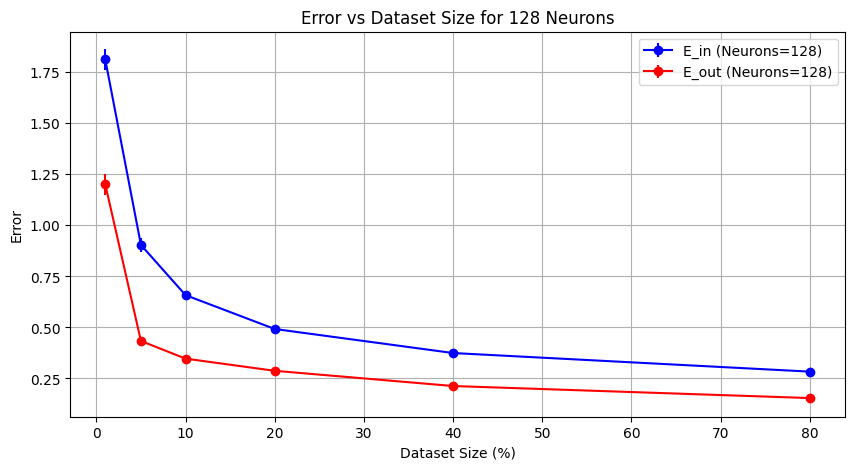

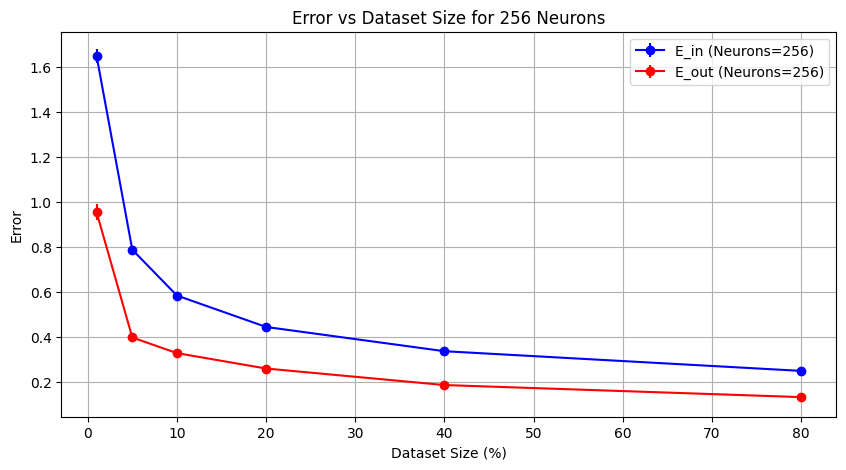

In [2]:
# Plotting results where x-axis is the dataset size and y-axis is the error
dataset_percentage = [int(ds_size * 100) for ds_size in dataset_sizes]

for s_index, s in enumerate(neuron_sizes):
    means_in = [results_in[ds_size][s_index][0] for ds_size in dataset_sizes]
    stds_in = [results_in[ds_size][s_index][1] for ds_size in dataset_sizes]

    means_out = [results_out[ds_size][s_index][0] for ds_size in dataset_sizes]
    stds_out = [results_out[ds_size][s_index][1] for ds_size in dataset_sizes]

    plt.figure(figsize=(10, 5))

    # Plot E_in
    plt.errorbar(dataset_percentage, means_in, yerr=stds_in, label=f"E_in (Neurons={s})", fmt='-o', color='blue')

    # Plot E_out
    plt.errorbar(dataset_percentage, means_out, yerr=stds_out, label=f"E_out (Neurons={s})", fmt='-o', color='red')

    plt.title(f"Error vs Dataset Size for {s} Neurons")
    plt.xlabel("Dataset Size (%)")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)
    plt.show()